In [1]:
%matplotlib inline
%load_ext memory_profiler

import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import graphtools as gt
import phate
from scipy import sparse
from scipy.stats import zscore 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import warnings
from adjustText import adjust_text
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils
import random


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [4]:
pdfp = '/home/ngr4/project/scnd/data/processed'
pfp = '/home/ngr4/project/scnd/results/'

%memit wtt = utils.load_adata(os.path.join(pdfp, 'hum_wt_imputed.h5ad'))
%memit mutt = utils.load_adata(os.path.join(pdfp, 'hum_sca1_imputed.h5ad'))


loaded @200716.15:55:08
took 3.82-s to load data
peak memory: 8508.91 MiB, increment: 4120.71 MiB
loaded @200716.15:55:15
took 6.70-s to load data
peak memory: 10431.46 MiB, increment: 6041.10 MiB


In [5]:
fname = 'hum_imp_by_genotype'

dge = pd.DataFrame()
for t in ['all']:
    print('\nstarting timepoint {}\n'.format(t))
    start_t=time.time()
    
    group='ctype'
    for i in wtt.obs[group].unique() :
        start = time.time()
        
        print('  group: {}\n'.format(i))
                
        X = wtt[((wtt.obs[group]==i)), :].layers['imputed']
        X_mut = mutt[((mutt.obs[group]==i)), :].layers['imputed']
        
        X = np.asarray(X)
        X_mut = np.asarray(X_mut)
        
        print('    Ncells in X:{}'.format(X.shape[0]))
        print('    Ncells in X_mut:{}\n'.format(X_mut.shape[0]))

        p = utils.mwu(X,X_mut,wtt.var_names) # directionality doesn't matter
        emd = scprep.stats.differential_expression(X_mut,X,
                                                   measure = 'emd',
                                                   direction='both', 
                                                   gene_names=wtt.var_names,
                                                   n_jobs=-1)
        emd['Gene']=emd.index
        emd=emd.drop(columns='rank')
        fc = utils.log2aveFC(X_mut,X,wtt.var_names.to_list())
        gene_mismatch = fc['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            fc = fc.loc[gene_mismatch,:]
            warnings.warn('Warning: {} genes dropped due to p-val NA.'.format((gene_mismatch==False).sum()))
        dt = pd.merge(p,fc,how='left',on="Gene")
        gene_mismatch = emd['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            emd = emd.loc[gene_mismatch,:]
        dt = pd.merge(dt,emd,how='left',on='Gene')
        dt['Cell type']=[i]*dt.shape[0]
        dt['timepoint']=[str(t)]*dt.shape[0]
        dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])
        
        dge = dge.append(dt, ignore_index=True)
        print('... computed in {:.2f}-s'.format(time.time()-start))
    print('\nFinished timepoint {} in {:.2f}-min'.format(t,(time.time()-start_t)/60))
    
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'dge_'+fname+'.csv'),index=False)
    if False:
        # bootstraps
        dge_min = dge.sort_values('pval').drop_duplicates(['Gene'])
        dge_min.to_csv(os.path.join(pfp,'dge_'+fname+'.csv'),index=False)




starting timepoint all

  group: Granule cell

    Ncells in X:14043
    Ncells in X_mut:19313

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 101.47-s
... 50% completed in 208.28-s
... 75% completed in 320.76-s

... mwu computed in 439.92-s



/home/ngr4/project/scripts/utils.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_corrected['pval_corrected'] = new_pvals[1]
/home/ngr4/project/scripts/utils.py:360: RuntimeWarning: divide by zero encountered in log2
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/home/ngr4/project/scripts/utils.py:360: RuntimeWarning: invalid value encountered in subtract
  'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 15 genes dropped due to p-val NA.
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
 

... computed in 497.58-s
  group: Bergmann glia

    Ncells in X:437
    Ncells in X_mut:1272

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 23.77-s
... 50% completed in 52.06-s
... 75% completed in 86.73-s

... mwu computed in 127.66-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 423 genes dropped due to p-val NA.


... computed in 133.60-s
  group: GABAergic interneuron 2

    Ncells in X:312
    Ncells in X_mut:353

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 20.81-s
... 50% completed in 46.81-s
... 75% completed in 79.01-s

... mwu computed in 117.31-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 717 genes dropped due to p-val NA.


... computed in 121.11-s
  group: Oligodendrocyte progenitor cell

    Ncells in X:184
    Ncells in X_mut:316

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 20.39-s
... 50% completed in 45.95-s
... 75% completed in 77.79-s

... mwu computed in 115.80-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 310 genes dropped due to p-val NA.


... computed in 119.31-s
  group: Astrocyte

    Ncells in X:408
    Ncells in X_mut:1430

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 23.64-s
... 50% completed in 52.61-s
... 75% completed in 87.84-s

... mwu computed in 129.26-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 12 genes dropped due to p-val NA.


... computed in 135.04-s
  group: Oligodendrocyte

    Ncells in X:871
    Ncells in X_mut:643

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 22.25-s
... 50% completed in 49.73-s
... 75% completed in 83.58-s

... mwu computed in 123.50-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 32 genes dropped due to p-val NA.


... computed in 128.79-s
  group: Microglia

    Ncells in X:106
    Ncells in X_mut:327

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 20.30-s
... 50% completed in 45.86-s
... 75% completed in 77.60-s

... mwu computed in 115.54-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 576 genes dropped due to p-val NA.


... computed in 118.96-s
  group: Pericyte

    Ncells in X:155
    Ncells in X_mut:305

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 20.08-s
... 50% completed in 45.41-s
... 75% completed in 77.02-s

... mwu computed in 114.73-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 244 genes dropped due to p-val NA.


... computed in 118.22-s
  group: GABAergic interneuron 1

    Ncells in X:349
    Ncells in X_mut:326

starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 21.13-s
... 50% completed in 47.60-s
... 75% completed in 80.32-s

... mwu computed in 119.27-s



/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Warning: 154 genes dropped due to p-val NA.


... computed in 123.16-s

Finished timepoint all in 24.93-min


In [11]:
mutt.obs['ctype'].unique()

[Granule cell, GABAergic interneuron 1, Pericyte, Astrocyte, Bergmann glia, Oligodendrocyte, Microglia, GABAergic interneuron 2, Oligodendrocyte progenitor cell]
Categories (9, object): [Granule cell, GABAergic interneuron 1, Pericyte, Astrocyte, ..., Oligodendrocyte, Microglia, GABAergic interneuron 2, Oligodendrocyte progenitor cell]

In [10]:
wtt.obs['ctype'].unique()

[Granule cell, Bergmann glia, GABAergic interneuron 2, Oligodendrocyte progenitor cell, Astrocyte, Oligodendrocyte, Microglia, Pericyte, GABAergic interneuron 1]
Categories (9, object): [Granule cell, Bergmann glia, GABAergic interneuron 2, Oligodendrocyte progenitor cell, ..., Oligodendrocyte, Microglia, Pericyte, GABAergic interneuron 1]

In [8]:
dge[
    'Cell type'
].unique()

array(['Granule cell', 'Bergmann glia', 'GABAergic interneuron 2',
       'Oligodendrocyte progenitor cell', 'Astrocyte', 'Oligodendrocyte',
       'Microglia', 'Pericyte', 'GABAergic interneuron 1'], dtype=object)

In [7]:
if True:
    # split into multipe files
    for ctype in dge['Cell type'].unique():
        dt = dge.loc[dge['Cell type']==ctype, :]
        dt.to_csv(os.path.join(pfp, 'dge_HumImpByGenotype_{}.csv'.format(ctype)))

# Volcano 

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


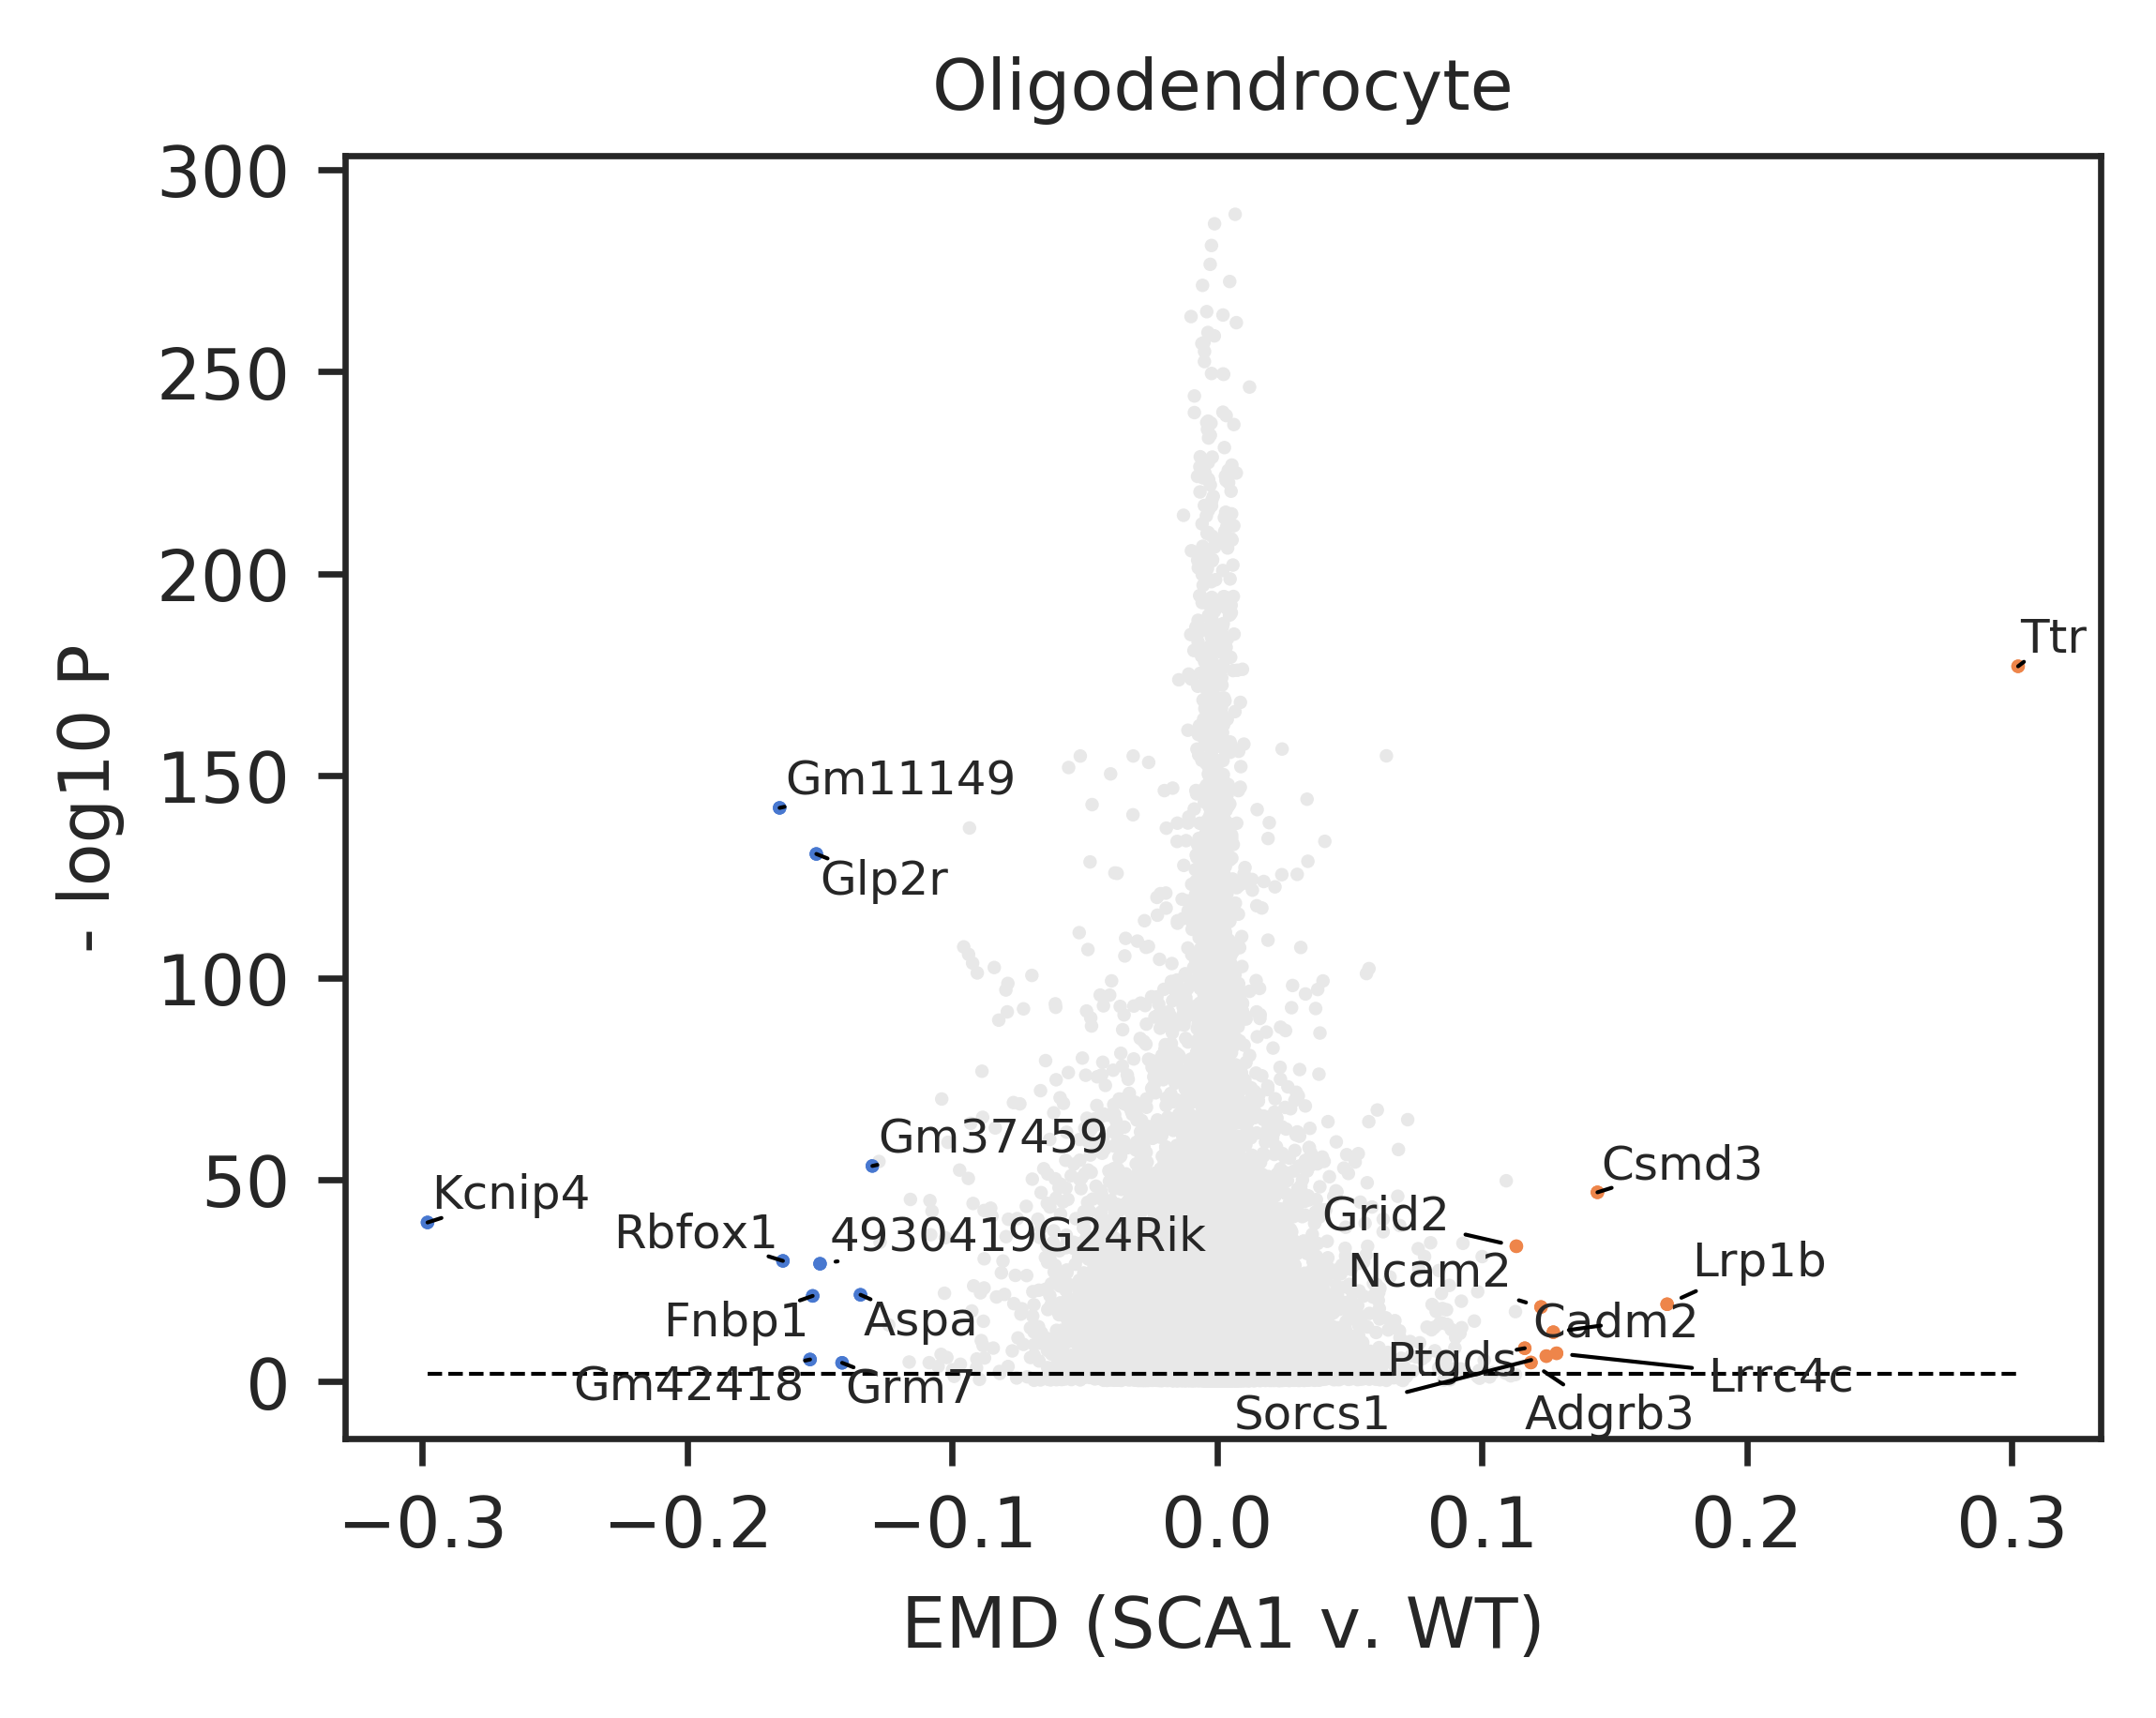

In [17]:
# filter the dge a bit
ctype = 'Oligodendrocyte'

# take pval uncorrected

if True:
    # load
    dge = pd.read_csv(os.path.join(pfp,'dge_'+fname+'.csv'))

# just work with plot of interest
dt = dge.loc[dge['Cell type']==ctype,['Gene','emd', 'pval', 'log2FC']]
dt['nlog10pval'] = -1*np.log10(dt['pval'])


if True:
    # drop mito, ribosomal, and MALAT1 genes
#     genes2exclude = [g for g in dt['Gene'] if 'mt-' in g or g.startswith('RPS') or g.startswith('RPL')] + ['MALAT1']
    genes2exclude = [g for g in dt['Gene'] if 'mt-' in g] + ['Malat1']
    dt = dt.loc[(~dt['Gene'].isin(genes2exclude)), :]


# get max pval of non-infinite ones and re-assign to inf ones
dt.loc[dt['nlog10pval'].isin([-np.inf, np.inf]), 'nlog10pval'] = np.ceil(dt.loc[~dt['nlog10pval'].isin([-np.inf, np.inf]), 'nlog10pval'].max())

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()

# just label top 10 and bottom 10
dt = dt.sort_values(by='emd') # sort by EMD
dt = dt.reset_index()
top10 = dt['Gene'][0:10].to_list()
bottom10 = dt['Gene'][-10:].to_list()
    
genes_volcano = {fname:top10+bottom10}


    
## aesthetics
cmap_volcano={'N.S.':'#E8E8E866','Up':sns.color_palette('muted')[1],
              'Down':sns.color_palette('muted')[0],'B.H. cutoff':'#E8E8E8'}
dt['Significance']=['N.S.']*dt.shape[0]
dt['Significance'][(dt['pval']<=0.01)]='B.H. cutoff'
dt['Significance'][((dt['pval']<=0.01) & (dt['log2FC']>0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Up'
dt['Significance'][((dt['pval']<=0.01) & (dt['log2FC']<0) & ([True if i in genes_volcano[fname] else False for i in dt['Gene']]))]='Down'

## plot
fig,ax=plt.subplots(1,1,figsize=(4,3))
p2=sns.scatterplot(x='emd',y='nlog10pval',
                  data=dt.loc[((dt['Significance']!='Up') | (dt['Significance']!='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
p2top=sns.scatterplot(x='emd',y='nlog10pval',
                  data=dt.loc[((dt['Significance']=='Up') | (dt['Significance']=='Down'))],
                   ax=ax,s=3,edgecolor='none',
                  palette=cmap_volcano,hue='Significance',legend=False,
                  rasterized=True)
ax.plot([dt['emd'].min(),dt['emd'].max()],
        (-1)*np.log10([0.01,0.01]),
        'k--',lw=0.5) # BH cut off
ax.set(xlabel='EMD (SCA1 v. WT)',ylabel='- log10 P', title=ctype)



idx_g={}
for g in genes_volcano[fname]: # match fname with dict key
    idx_g[g]=[i for i,v in enumerate(dt['Gene']) if v==g][0] # assumes unique namees

texts = [ax.text(dt['emd'][i],dt['nlog10pval'][i],g,fontsize=6) for g,i in idx_g.items()]
adjust_text(texts,arrowprops=dict(arrowstyle="-", color='k', lw=0.5),ax=ax)

if True :
    # save plot
    fig.savefig(os.path.join(pfp,'volcano_{}_{}.pdf'.format(fname,ctype)),dpi=300, bbox_inches='tight')




In [76]:
adata.obs['Infected'] = adata.obs['scv2_geq1'].map({1:'Infected', 0:'Bystander'})
adata.obs.loc[adata.obs['Condition']=='Mock', 'Infected'] = 'Mock'
adata.obs['Infected'] = adata.obs['Infected'].astype('category')

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


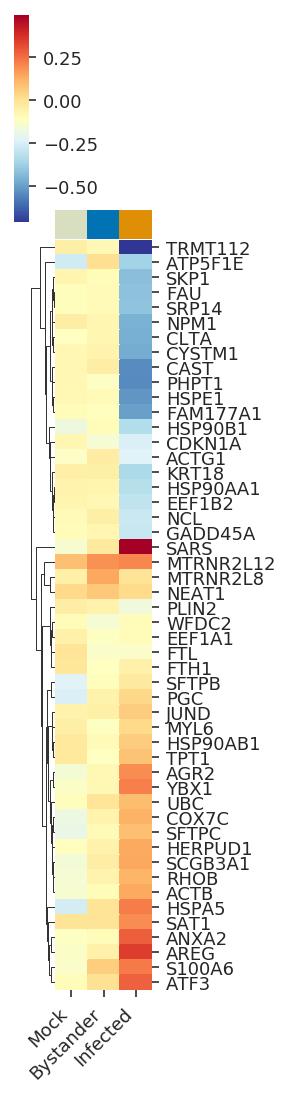

In [94]:
# HEATMAP
cmap_infected = {'Mock':sns.cubehelix_palette(4, start=.5, rot=-.75)[0],
                 'Bystander':sns.color_palette('colorblind')[0],
                 'Infected':sns.color_palette('colorblind')[1]}

# grab top25 up and down (assume dt sorted)
n = 25
topn = dt['Gene'][0:n].to_list()
bottomn = dt['Gene'][-n:].to_list()
    
genes_heatmap = {fname:topn+bottomn}

# construct dataframe
X = pd.DataFrame(np.asarray(adata[:,genes_heatmap[fname]].X.todense()), 
                columns=genes_heatmap[fname])
X['Cell type'] = adata.obs['init_ctype'].astype(str).to_list()
X['Infected'] = adata.obs['Infected'].astype(str).to_list()

x = X
x.loc[:,genes_heatmap[fname]] = zscore(x.loc[:,genes_heatmap[fname]]) # over whole dataset
x = X.loc[X['Cell type']==ctype,:]


x['Infected'] = x['Infected'].astype('category')

ave_zscore = x.groupby(['Infected']).mean().T
order = ['Mock', 'Bystander', 'Infected']
ave_zscore = ave_zscore[order]
p = sns.clustermap(
    ave_zscore,
    method='average',
    metric='euclidean',
    z_score=None,
    standard_scale=None,
    figsize=(2,8),
    cbar_kws=None,
    row_cluster=True,
    col_cluster=False,
    row_linkage=None,
    col_linkage=None,
    row_colors=None,
    col_colors=list(map(cmap_infected.get, order)),
    mask=None,
    cmap='RdYlBu_r',
    yticklabels=True,
#     vmin=-2,vmax=2,
)
p.ax_heatmap.set_xlabel('')
p.ax_heatmap.set_xticklabels(order, rotation=45, ha='right')

if True:
    p.savefig(os.path.join(pfp,'heatmap_top25updown_{}_{}.png'.format(fname,ctype)),dpi=300,bbox_inches='tight')